# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [1]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [12]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, cerca occorrenze di parole chiave e computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.
$$\newcommand{\pluseq}{\mathrel{+}=}$$
A seguire i criteri per assegnare lo score:
$$"sostenibilita"\;in\;(\,filename\,or\,anchor\,) \implies score \pluseq 40$$
$$"ambiente"\;or\;"bilancio"\;or\;"rapporto"\;in\;(\,filename\,or\,anchor\,) \implies score \pluseq 20$$
$$"sostenibilita"\;or\;"ambiente"\;in\;(\,url\,) \implies score \pluseq 10$$

Dopo aver calcolato il punteggio, nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [13]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:

$$tsh \in(\,40, \,60\,)$$

$$(1)\; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$
$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$
$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$
$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$
$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [2]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data/function")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

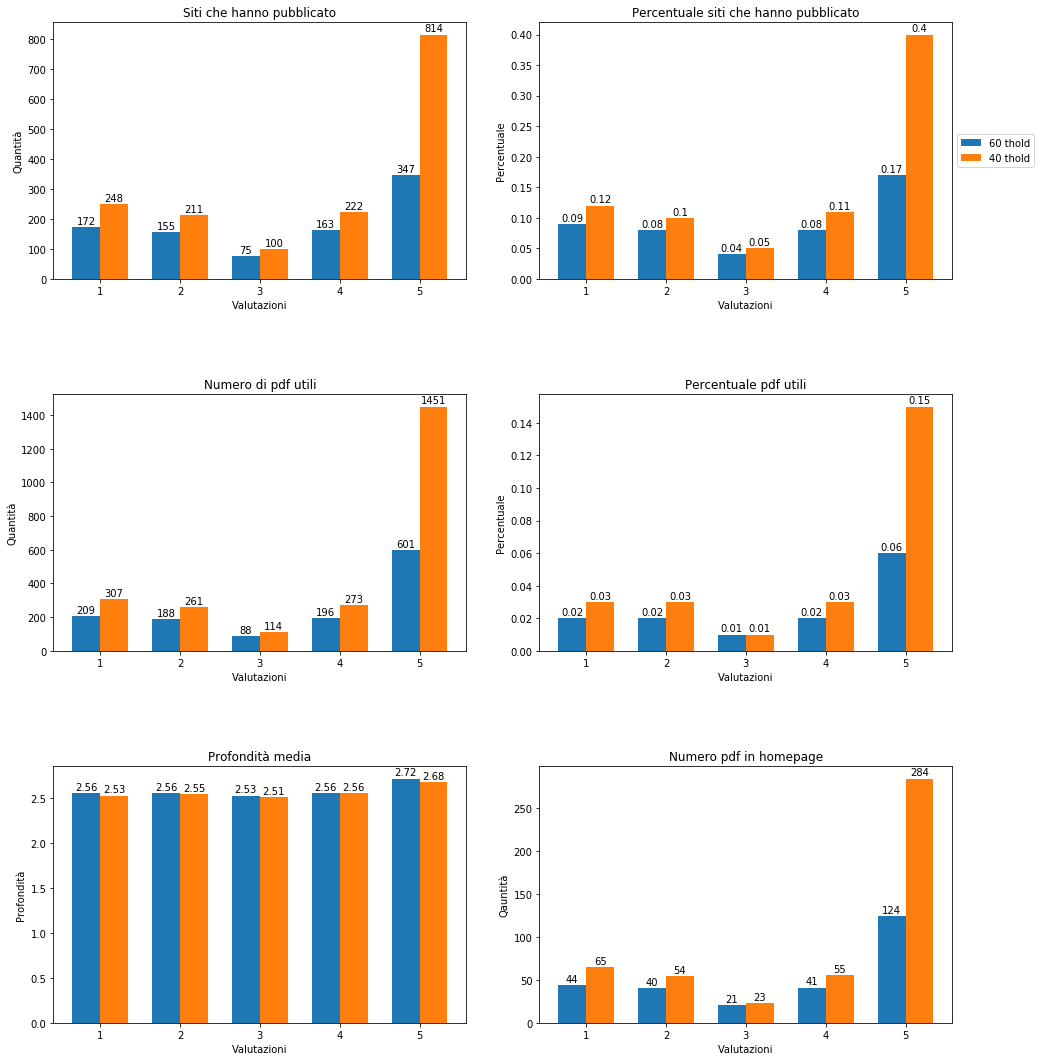

In [68]:
generate_plot(stp)

# Classificatore

Dopo un primo approccio con la funzione di valutazione, si è pensato alla creazione di un classificatore per i link.

Il modello usato è un __support vector machine__, visti gli ottimi risultati sulla lista completa di link.

## Dataset

Le features sono le stesse prese in considerazione dalla funzione di valutazione precedente, ovvero la presenza delle keyword sostenibilità, ambiente, report, bilancio e di 2018 negli elementi del link.

Il dataset è stato creato prendendo come sample positivi i link utili trovati dalla funzione discussa in precedenza, aggiungendo a mano alcuni esempi scartati, trovati riducendo il valore della threshold.

Per gli esempi negativi invece sono stati considerati i link che presentavano più caratteristiche positive, così da rendere il training più difficile e poter capire esattamente quali features determinassero l'utilità o meno di un documento.

In [57]:
dataset_path = "links_classifiers/data/dataset.csv"
data = pd.read_csv(dataset_path)
data.sample(n=5)

,k1_filename,k1_anchor,k1_url,k2_filename,k2_anchor,k2_url,k3_filename,k3_anchor,k3_url,k4_filename,k4_anchor,k4_url,18_filename,18_anchor,18_url,label
517,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0
94,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1
170,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1
438,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0
708,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0


## Training

A seguire il training del modello: per semplicità la funzione __generate_svm()__ restituisce un modello già allenato, il nome __c_8_0__ indica il caricamento del modello con parametro c = 8, quello con risultati migliori.

In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from links_classifiers import generate_svm

# generate_svm restituisce una svm allenata sul dataset successivo
s = generate_svm(load_name = 'c_8_0')

# split del training set per testare accuracy e confusion matrix
X = data[data.columns[:-1]]
Y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

y_pred = s.predict(X_test)
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nConfusion matrix:\n{}".format(metrics.confusion_matrix(y_test, y_pred)))

Accuracy: 0.9868421052631579

Confusion matrix:
[[119   2]
 [  1 106]]


## Link di esempio

Provando a riclassificare i link di esempio creati in precedenza, si nota che i link utili sono ritenuti positivi con una probabilità del 97 percento, mentre il link negativo, ma dubbio, risulta non utile al 64 percento.

In [14]:
from csv_links_processing import evaluate_classifier

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Prediction: %s \nProbability: %f \n" %evaluate_classifier(l, s))

Prediction: True 
Probability: 0.970575 

Prediction: True 
Probability: 0.969655 

Prediction: False 
Probability: 0.648720 



# File processing

Dopo aver ottenuto la lista di link utili dal classificatrore, i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili, sono presenti inoltre casi nei quali link differenti presenti su un sito web portano allo stesso file.

In [3]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,373
1,file to process,198
2,file processed,187


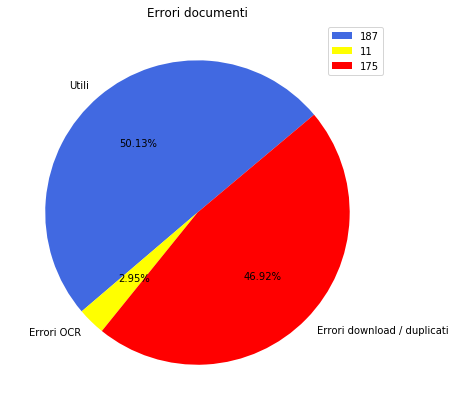

In [6]:
labels = 'Utili', 'Errori OCR', 'Errori download / duplicati'
val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'r']

fig1, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=40)
ax.set_title("Errori documenti")
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

## Statistiche popolazione

La popolazione dell'indice si basa su richieste alle API Atoka e Dandelion.
È possibile che alcuni report siano stati pubblicati da aziende le cui informazioni non siano totalmente o parzialmente reperibili tramite Atoka, alcuni pdf sono stati quindi scartati e sono presenti documenti elastic incompleti, che presentano ad esempio la mancanza dell'indirizzo dell'azienda, del codice ateco, dei ricavi o del numero di dipendenti.

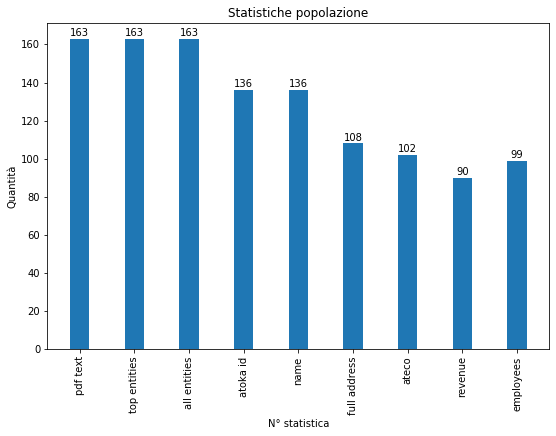

In [3]:
from elasticsearch_utilities import generate_plot

stats_path = "elasticsearch_utilities/stats/population.csv"
generate_plot(stats_path)

# Analisi: Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, che quelle principali.

# Modelli su tutte le entità

Il numero di entità presente per ogni documento è abbastanza alto, in media sono presenti __2496__ entità.

È stato creato un modello con l'insieme completo di entità, senza alcun vincolo, poi sono stati considerati dei vincoli di frequenza tra documenti e all'interno di un singolo documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta vicoli sulle keyword, si cercano quindi i topics considerando la lista completa di entità estratte dal testo.

### Preprocessing
Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. _dtm_tf_ : frequency vector
2. _tf_vectorizer_ : count vectorizer contentente il vocabolario estratto dai documenti

In [4]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Sustainability Sustainability Recipharm Reciph...
1,2,Sustainability History Scientific_research Sus...
2,3,Wolford Sustainability Wolford Financial_state...
3,4,Rosia_Montana Value_added Recycling circular_E...
4,5,United_States_dollar Sustainability Sustainabi...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [5]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 25044

Words:
'sustainability' : 21542
'recipharm' : 18515
'ethics' : 7666
'accountability' : 664
'value_' : 23686
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

### Parametri 
Nella creazione del modello bisogna tenere conto del numero di argomenti da trovare e di due parametri alpha e beta.

I valori di __alpha__ e __beta__ controllano rispettivamente:
1. quanti topics fanno parte di un documento: per un valore basso si assume che ogni documento sia composto da pochi topics 
2. quante parole compongono ogni topic: un valore più basso fa assumere al modello che ogni topic sia composto da poche keyword specifiche.
    
Per tutti i modelli che seguono, i parametri __topics__,  __alpha__ e __beta__ sono stati impostati per avere la maggior divisione e chiarezza possibile nella presentazione della distribuzione degli argomenti nei documenti.

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

topics = 13
alpha = 0.4
beta =  0.3

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.126851 -0.248477       1        1  51.730424
6     -0.240920  0.098747       2        1  13.012160
11    -0.001115 -0.087314       3        1   5.923507
5     -0.145691  0.128335       4        1   5.908150
4     -0.021366 -0.140547       5        1   4.892012
2     -0.117227  0.140108       6        1   4.337332
0      0.068712 -0.028284       7        1   3.391878
10     0.048460 -0.037438       8        1   3.258431
12     0.061359 -0.038035       9        1   3.093315
9      0.081553 -0.045359      10        1   1.933870
8      0.131037  0.084033      11        1   1.110136
3      0.123249  0.071495      12        1   0.903072
7      0.138799  0.102734      13        1   0.505714, topic_info=                                                 Term         Freq  \
21542                                  sustainability  9400.000000   
21564                   sustainable_development_goals  1425.000000   
7263                                       employment  8390.000000   
21497                                    supply_chain  3243.000000   
13333                                         machine  1021.000000   
...                                               ...          ...   
18279  race_and_ethnicity_in_the_united_states_census     2.398559   
19723                                         science     3.395514   
5711                                         currency     2.947961   
3678                                carbon_neutrality     2.489325   
11644                                         ireland     2.413735   

             Total Category  logprob  loglift  
21542  9400.000000  Default  30.0000  30.0000  
21564  1425.000000  Default  29.0000  29.0000  
7263   8390.000000  Default  28.0000  28.0000  
21497  3243.000000  Default  27.0000  27.0000  
13333  1021.000000  Default  26.0000  26.0000  
...            ...      ...      ...      ...  
18279    19.515249  Topic13  -6.8583   3.1906  
19723   328.250202  Topic13  -6.5107   0.7156  
5711    121.921102  Topic13  -6.6520   1.5647  
3678     83.015206  Topic13  -6.8211   1.7799  
11644    69.522803  Topic13  -6.8520   1.9265  

[848 rows x 6 columns], token_table=       Topic      Freq                                           Term
term                                                                 
146        1  0.573081  2015_united_nations_climate_change_conference
146       12  0.214905  2015_united_nations_climate_change_conference
363        4  0.917387                                     _decathlon
364       12  0.510787                                        _decker
400        2  0.946797                               _italian_petroli
...      ...       ...                                            ...
24814      7  0.821330                                        wwe_raw
24864      7  0.915940                                   yankee_group
24967      8  0.984877                                        zermelo
24978      4  0.006773                             zf_friedrichshafen
24978      8  0.975338                             zf_friedrichshafen

[2326 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 12, 6, 5, 3, 1, 11, 13, 10, 9, 4, 8])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue sono stati impostati dei vincoli di frequenza, un' entità viene considerata a patto che:
1. compaia in almeno __N__ documenti distinti
2. compaia almeno __M__ volte all'interno di un documento

L'obiettivo è quello di scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio e quei termini secondari all'interno di un documento.

### Grandezza vocabolario

A seguire la grandezza del vocabolario in relazione ai valori __N__ ed __M__.

Tenendo presente che:
- il __totale__ dei __documenti__ è di __170__.
- il numero __medio__ di __entità__ trovate in un testo è di __2496__

si può notare che anche valori molto piccoli di N ed M riducono di molto la grandezza del vocabolario.

Il grafico non presenta l'andamento completo, ma solo la parte iniziale in cui si nota un decremento esponenziale della dimensione.

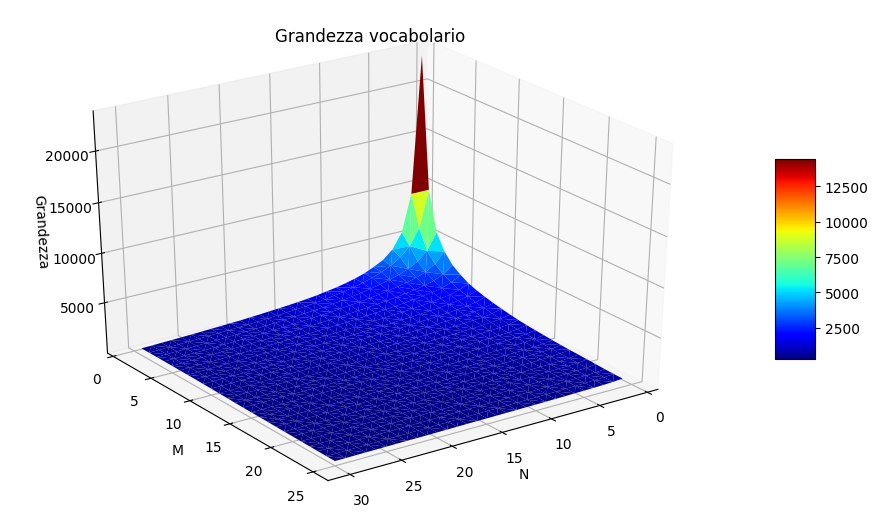

In [2]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

### Modello

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le __restrizioni__ discusse sopra.

Avendo una restrizione sulla frequenza, è opportuno cambiare i parametri del modello, in particolare, si cercano __meno topics__, poichè con il vincolo di frequenza si eliminano gli argomenti troppo specifici per ogni documento. Come conseguenza sono cambiati opportunamente anche i parametri alpha e beta, coem discusso in precedenza.

A seguire il modello che considera solo i termini presenti in almeno il __25%__ dei __documenti__ e presenti almeno __15__ volte all'interno di un singolo documento.

In [7]:
from lda_topic_model import preprocess_freq_count

N = round(170 * 0.25)
M = 15

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 13
alpha = 0.4
beta = 0.7

topics = 10
alpha = 0.7
beta = 0.2


lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 331

Words:
'sustainability' : 284
'employment' : 89
'supply_chain' : 282
'company' : 49
'management' : 169
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.180094  0.027758       1        1  31.037389
7      0.152988 -0.041058       2        1  14.568105
4      0.162683  0.056612       3        1  13.566586
9     -0.283069 -0.017526       4        1   9.737711
3      0.054362  0.034577       5        1   7.939826
5     -0.276093  0.100690       6        1   5.695720
8      0.060834  0.147874       7        1   5.452280
6      0.137714  0.107623       8        1   5.183473
2      0.058880 -0.371828       9        1   4.460324
1     -0.248392 -0.044720      10        1   2.358586, topic_info=                              Term         Freq        Total Category  \
287  sustainable_development_goals  1541.000000  1541.000000  Default   
284                 sustainability  9617.000000  9617.000000  Default   
102                           euro  1596.000000  1596.000000  Default   
89                      employment  8420.000000  8420.000000  Default   
258                        service  1211.000000  1211.000000  Default   
..                             ...          ...          ...      ...   
77                         economy    32.725613  1279.103092  Topic10   
279                       strategy    31.805794  1053.462110  Topic10   
109                        finance    29.624363   758.829962  Topic10   
209                         policy    29.785906  1209.474382  Topic10   
102                           euro    29.394721  1596.096390  Topic10   

     logprob  loglift  
287  30.0000  30.0000  
284  29.0000  29.0000  
102  28.0000  28.0000  
89   27.0000  27.0000  
258  26.0000  26.0000  
..       ...      ...  
77   -4.6378   0.0814  
279  -4.6663   0.2469  
109  -4.7373   0.5039  
209  -4.7319   0.0432  
102  -4.7451  -0.2474  

[524 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
0         6  0.142384                accounting
0         7  0.726159                accounting
0         8  0.121027                accounting
1         4  0.278240               agriculture
1         8  0.719143               agriculture
...     ...       ...                       ...
327       5  0.956042              working_time
328       2  0.894526                 workplace
329       1  0.356378                     world
329      10  0.617721                     world
330       3  0.971234  world_energy_consumption

[977 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 5, 10, 4, 6, 9, 7, 3, 2])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di __entità principali__.

La lista di entità questa volta non contiene doppioni, si può pensare alle entità principali come a un set ordinato per importanza, cambierà quindi il criterio di frequenza, essendo il precedente inapplicabile nella parte di conteggio delle occorrenze all'interno di ogni documento.  

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei __modelli__ più __specifici__.

Anche in questo caso è inizialmente considerato l'insieme totale di entità e successivamente quello ristretto per il nuovo criterio di frequenza, che questa volta non considererà il vincolo intra-documento.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà. Bisogna però tenere presente che il numero medio di entità principali per ogni testo è di 250, molto minore di 2496, media del numero di entità complete.

In [8]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")
print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 9803

Words:
'sustainability' : 8479
'recipharm' : 7272
'ethics' : 2957
'accountability' : 188
'value_' : 9296
...


Per la scelta dei parametri nel modello, si è __ridotto__ il numero di __topics__, sistemando quindi alpha e beta.

In [9]:
topics = 11
alpha = 0.02
beta =  0.07

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.255493  0.051727       1        1  43.455163
9      0.067941  0.232453       2        1  17.904507
0     -0.168773 -0.012033       3        1  10.639913
8      0.115187  0.153823       4        1   6.025661
4      0.083216  0.112819       5        1   5.925207
6     -0.113948 -0.027047       6        1   5.171948
3     -0.060066 -0.064629       7        1   3.750367
2      0.064100 -0.114057       8        1   2.804354
10     0.037580 -0.089843       9        1   2.675497
5      0.114832 -0.137156      10        1   1.155877
1      0.115424 -0.106057      11        1   0.491506, topic_info=            Term        Freq       Total Category  logprob  loglift
7462       right  116.000000  116.000000  Default  30.0000  30.0000
1188    business  350.000000  350.000000  Default  29.0000  29.0000
3240     finance  195.000000  195.000000  Default  28.0000  28.0000
4636       italy   90.000000   90.000000  Default  27.0000  27.0000
2779  employment  119.000000  119.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
6928      profit    0.310080   14.883879  Topic11  -6.5802   1.4442
3593     gender_    0.286856   15.923677  Topic11  -6.6580   1.2989
5084    literacy    0.262749    1.779469  Topic11  -6.7458   3.4026
7822     senegal    0.262749    2.773739  Topic11  -6.7458   2.9587
8708       texas    0.262749    3.106566  Topic11  -6.7458   2.8454

[1135 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
23        3  0.983974              20
70        2  0.848455              9p
70        4  0.094273              9p
84        7  0.509955          _hertz
85        7  0.509955  _hobby_airport
...     ...       ...             ...
9763      1  0.498963           youth
9763      2  0.299378           youth
9763      6  0.099793           youth
9763     10  0.099793           youth
9775      8  0.488827        zea_mays

[1977 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 1, 9, 5, 7, 4, 3, 11, 6, 2])

## Modello con vincoli di frequenza - entità principali

Il criterio per il vincolo di frequenza cambia: 
1. __N__ rimane lo stesso, ovvero specifica la __frequenza inter-documento__ di un' entità.
2. __M__ questa volta diventa la __quantità__ di __entità considerate__ per ogni documento. Un paramentro piccolo indicherà la considerazione delle parole più importanti, mentre un paramentro alto comprenderà una quantità di parole, meno importanti, più elevata.

Per quanto riguarda la restrizione di frequenza inter-documento, ovvero sul parametro N, l'andamento della curva decresce in modo esponenziale, in linea con la curva nell'esempio precedente.

Per quanto riguarda il paramentro M, questa volta porta ad un incremento lineare del vocabolario, poichè ad ogni step si include un numero di entità proporzionale al totale dei documenti.

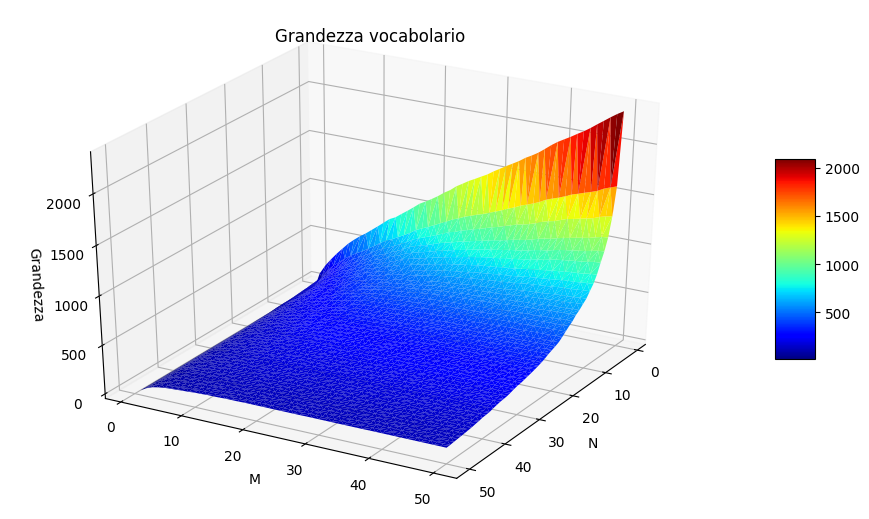

In [3]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path, en="top")

Il modelli che seguono mantengono la restrizione della frequenza adottata in precedenza per quanto riguarda N, ovvero si considerano i termini presenti nel __25%__ dei __documenti__, mentre per __M__ si usano __50__ e __30__ rispettivamente.

### M = 50

In [10]:
from lda_topic_model import preprocess_freq_count_relevant

N = round(170 * 0.25)
M = 50

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 10
alpha = 0.9
beta = 0.2

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 190

Words:
'sustainability' : 166
'ethics' : 54
'value_' : 179
'stakeholder_' : 160
'corporate' : 28
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.170778 -0.027713       1        1  14.830858
5      0.237178 -0.136680       2        1  14.712428
7     -0.095077 -0.109696       3        1  13.608454
0     -0.125976  0.011370       4        1  11.951800
2     -0.115473  0.017139       5        1  10.771505
9     -0.088819 -0.028929       6        1   9.569915
3     -0.067972  0.113787       7        1   8.114480
4      0.139357  0.121710       8        1   6.222945
1      0.160744  0.115613       9        1   5.156928
6      0.126815 -0.076600      10        1   5.060687, topic_info=               Term        Freq       Total Category  logprob  loglift
56           europe   33.000000   33.000000  Default  30.0000  30.0000
170      technology   49.000000   49.000000  Default  29.0000  29.0000
166  sustainability  142.000000  142.000000  Default  28.0000  28.0000
129       recycling   25.000000   25.000000  Default  27.0000  27.0000
81      information   48.000000   48.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
96       management    1.488097   61.096350  Topic10  -5.0136  -0.7313
9          business    2.392883  141.969658  Topic10  -4.5386  -1.0994
54           ethics    1.560616   76.493716  Topic10  -4.9661  -0.9085
22    communication    0.632994   20.108477  Topic10  -5.8684  -0.4748
43        education    0.563005   23.722168  Topic10  -5.9856  -0.7572

[427 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.237288     accounting
0         3  0.118644     accounting
0         6  0.474577     accounting
1         1  0.181898  air_pollution
1         4  0.682117  air_pollution
...     ...       ...            ...
189       2  0.166299          world
189       5  0.066520          world
189       7  0.199559          world
189       8  0.166299          world
189       9  0.365858          world

[636 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 8, 1, 3, 10, 4, 5, 2, 7])

### M = 30

In [11]:
N = round(170 * 0.25)
M = 30

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 10
alpha = 0.7
beta = 0.3

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 186

Words:
'sustainability' : 162
'ethics' : 53
'value_' : 175
'stakeholder_' : 157
'corporate' : 27
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.226225  0.024832       1        1  16.756376
8      0.101752  0.099371       2        1  13.805759
6      0.063324  0.019341       3        1  11.030464
0      0.096395 -0.089813       4        1  10.856941
5      0.087711 -0.050168       5        1  10.782013
7      0.088640 -0.135679       6        1   9.390244
1     -0.027665  0.003685       7        1   7.656398
3      0.016585  0.133937       8        1   6.875902
4     -0.210780 -0.078279       9        1   6.572607
9      0.010264  0.072773      10        1   6.273296, topic_info=               Term       Freq       Total Category  logprob  loglift
9          business  98.000000   98.000000  Default  30.0000  30.0000
40        economics  58.000000   58.000000  Default  29.0000  29.0000
47           energy  28.000000   28.000000  Default  28.0000  28.0000
175          value_  47.000000   47.000000  Default  27.0000  27.0000
53           ethics  45.000000   45.000000  Default  26.0000  26.0000
..              ...        ...         ...      ...      ...      ...
41          economy   3.402370   43.092522  Topic10  -3.9712   0.2300
175          value_   3.566840   47.022342  Topic10  -3.9240   0.1899
162  sustainability   4.721104  109.971514  Topic10  -3.6436  -0.3793
23          company   3.740192   65.742142  Topic10  -3.8765  -0.0977
29      corporation   2.398239   33.823681  Topic10  -4.3209   0.1224

[406 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         2  0.476706     accounting
1         5  0.743888  air_pollution
1        10  0.148778  air_pollution
2         3  0.429639       analysis
2        10  0.286426       analysis
...     ...       ...            ...
184      10  0.561115      workforce
185       1  0.198256          world
185       4  0.132171          world
185       6  0.198256          world
185       9  0.330427          world

[551 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 7, 1, 6, 8, 2, 4, 5, 10])